<a href="https://colab.research.google.com/github/WonJunPark/img_recog/blob/master/copy_resnext_xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Resnext & Xception Ensemble (Inference)

※본 커널은 캐글을 통해 공유된 https://www.kaggle.com/khoongweihao/xception-resnext-ensemble-inference 의 내용을 기반으로 작성되었습니다.

※필요한 기능들을 Optional 로 추가하였습니다.



# Colab 사용을 위한 환경 설정

In [0]:
use_colab = True

In [11]:
if use_colab == True:
  from google.colab import drive
  drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
if use_colab == True:
  work_root_path = "/content/gdrive/My Drive/Kaggle/DFDC/"
else:
  work_root_path = "../"      # src directory 의 상위로 옮김

In [13]:
cd "/content/gdrive/My Drive"

/content/gdrive/My Drive


# Resnext & Xception Ensemble (Inference)

- 이 커널은 https://www.kaggle.com/khoongweihao/frames-per-video-viz 및 https://www.kaggle.com/greatgamedota/xception-binary-classifier-inference (original 아님, learning rate 와 epochs 수정함)의 결과 앙상블을 출력합니다.
- 비디오 당 프레임 수 64 (가장 좋음)

# 1 Common

## 1.1 Install

In [0]:
if use_colab == True:
  !pip install ./Kaggle/DFDC/deepfake-xception-trained-model/pytorchcv-0.0.55-py2.py3-none-any.whl --quiet
else:
  !pip install ../Kaggle/DFDC/deepfake-xception-trained-model/pytorchcv-0.0.55-py2.py3-none-any.whl --quiet

## 1.2 Import

In [0]:
import datetime

In [0]:
import os, sys, time
import cv2
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## 1.3 Prepare and Load Data

In [21]:
if use_colab == True:
  train_dir = "/content/gdrive/My Drive/Kaggle/DFDC/deepfake-detection-challenge/train_sample_videos/"

# train_dir 디렉토리에 있는 파일을 정렬해서 train_videos 로 목록을 만든다
train_videos = sorted([x for x in os.listdir(train_dir) if x[-4:] == ".mp4"])
len(train_videos)  

356

In [22]:
if use_colab == True:
  test_dir = "/content/gdrive/My Drive/Kaggle/DFDC/deepfake-detection-challenge/test_videos/"
  
# test_dir 디렉토리에 있는 파일을 정렬해서 test_videos 로 목록을 만든다
test_videos = sorted([x for x in os.listdir(test_dir) if x[-4:] == ".mp4"])
len(test_videos)

400

In [23]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 1.4.0
CUDA version: 10.1
cuDNN version: 7603


In [24]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

In [0]:
import sys

if use_colab == True:
  sys.path.insert(0, work_root_path + "blazeface-pytorch")
  sys.path.insert(0, work_root_path + "deepfakes-inference-demo")
  sys.path.insert(0, work_root_path + "deepfakes-inference-demo/helpers")

In [0]:
from blazeface import BlazeFace

# weight 와 anchor 를 load 한다.
facedet = BlazeFace().to(gpu)
if use_colab == True:
  facedet.load_weights(work_root_path + "deepfake-detection-challenge/blazeface/blazeface.pth")
  facedet.load_anchors(work_root_path + "deepfake-detection-challenge/blazeface/anchors.npy")

# ???  
_ = facedet.train(False)

In [0]:
from helpers.read_video_1 import VideoReader
from helpers.face_extract_1 import FaceExtractor

### 1.3.1 Additional Prepare (Optional)

In [0]:
TRAIN_SAMPLE_FOLDER = 'train_sample_videos'
TEST_FOLDER = 'test_videos'

In [34]:
input_path = "/content/gdrive/My Drive/Kaggle/DFDC/deepfake-detection-challenge"
train_list = list(os.listdir(os.path.join(input_path, TRAIN_SAMPLE_FOLDER)))
ext_dict = []
for file in train_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_dict):
        ext_dict.append(file_ext)
print(f"Extensions: {ext_dict}")      

Extensions: ['json', 'mp4']


In [35]:
json_file = [file for file in train_list if  file.endswith('json')][0]
print(f"JSON file: {json_file}")

JSON file: metadata.json


In [0]:
def get_meta_from_json(path):
    df = pd.read_json(os.path.join(input_path, path, json_file))
    df = df.T
    return df

meta_train_df = get_meta_from_json(TRAIN_SAMPLE_FOLDER)

In [37]:
meta_train_df.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [38]:
meta_train_df.tail()

,label,split,original
etejaapnxh.mp4,FAKE,train,wtreibcmgm.mp4
etmcruaihe.mp4,FAKE,train,afoovlsmtx.mp4
etohcvnzbj.mp4,FAKE,train,bdnaqemxmr.mp4
eudeqjhdfd.mp4,REAL,train,None
eukvucdetx.mp4,FAKE,train,gjypopglvi.mp4


## 1.4 Function

In [0]:
def predict_on_video(video_path, batch_size, input_size):
    try:
        # Find the faces for N frames in the video.
        faces = face_extractor.process_video(video_path)

        # Only look at one face per frame.
        face_extractor.keep_only_best_face(faces)
        
        if len(faces) > 0:
            # NOTE: When running on the CPU, the batch size must be fixed
            # or else memory usage will blow up. (Bug in PyTorch?)
            x = np.zeros((batch_size, input_size, input_size, 3), dtype=np.uint8)

            # If we found any faces, prepare them for the model.
            n = 0
            for frame_data in faces:
                for face in frame_data["faces"]:
                    # Resize to the model's required input size.
                    # We keep the aspect ratio intact and add zero
                    # padding if necessary.                    
                    resized_face = isotropically_resize_image(face, input_size)
                    resized_face = make_square_image(resized_face)

                    if n < batch_size:
                        x[n] = resized_face
                        n += 1
                    else:
                        print("WARNING: have %d faces but batch size is %d" % (n, batch_size))
                    
                    # Test time augmentation: horizontal flips.
                    # TODO: not sure yet if this helps or not
                    #x[n] = cv2.flip(resized_face, 1)
                    #n += 1

            if n > 0:
                x = torch.tensor(x, device=gpu).float()

                # Preprocess the images.
                x = x.permute((0, 3, 1, 2))

                for i in range(len(x)):
                    x[i] = normalize_transform(x[i] / 255.)

                # Make a prediction, then take the average.
                with torch.no_grad():
                    y_pred = model(x)
                    y_pred = torch.sigmoid(y_pred.squeeze())
                    return y_pred[:n].mean().item()

    except Exception as e:
        print("Prediction error on video %s: %s" % (video_path, str(e)))

    return 0.5

In [0]:
from concurrent.futures import ThreadPoolExecutor

# videos(비디오 리스트)를 받아서 predictions(판정 리스트)를 반환한다.  
def predict_on_video_set(videos, num_workers, input_size, video_dir=test_dir):
    def process_file(i):
        filename = videos[i]
        y_pred = predict_on_video(video_path=os.path.join(video_dir, filename), batch_size=frames_per_video, input_size=input_size)
        return y_pred

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        predictions = ex.map(process_file, range(len(videos)))

    return list(predictions)

In [0]:
# ???

frames_per_video = 64

video_reader = VideoReader()
video_read_fn = lambda x: video_reader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn, facedet)

In [0]:
from torchvision.transforms import Normalize

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)

In [0]:
def isotropically_resize_image(img, size, resample=cv2.INTER_AREA):
    h, w = img.shape[:2]
    if w > h:
        h = h * size // w
        w = size
    else:
        w = w * size // h
        h = size

    resized = cv2.resize(img, (w, h), interpolation=resample)
    return resized


def make_square_image(img):
    h, w = img.shape[:2]
    size = max(h, w)
    t = 0
    b = size - h
    l = 0
    r = size - w
    return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

## 1.5 Scoring (Optional)
Submissions are scored on log loss:
$$ LogLoss = - \frac{1}{n} \sum\limits_{i=1}^n [y_i \cdot log_e(\hat{y_i}) + (1-y_i) \cdot log_e(1-\hat{y_i})]  $$
where:
- $n$ is the number of videos being predicted
- $y^i$ is the predicted probability of the video being FAKE
- $y_i$ is 1 if the video is FAKE, 0 if REAL
- $log()$ is the natural (base e) logarithm


In [44]:
# SKLearn Implemention
from sklearn.metrics import log_loss
log_loss(["REAL", "FAKE", "FAKE", "REAL"],
         [[.1, .9], [.9, .1], [.8, .2], [.35, .65]])

0.21616187468057912

# 2 Resnext Model

In [0]:
input_size = 224      # Resnext input image size

In [0]:
class MyResNeXt(models.resnet.ResNet):
    def __init__(self, training=True):
        super(MyResNeXt, self).__init__(block=models.resnet.Bottleneck,
                                        layers=[3, 4, 6, 3], 
                                        groups=32, 
                                        width_per_group=4)
        self.fc = nn.Linear(2048, 1)

## 2.1 Resnext Model Load

In [0]:
# resnext 모델 load
if use_colab == True:
  checkpoint = torch.load(work_root_path + "deepfakes-inference-demo/resnext.pth", map_location=gpu)

# resnext 모델 eval
model = MyResNeXt().to(gpu)
model.load_state_dict(checkpoint)
_ = model.eval()

del checkpoint

## 2.2 Resnext Prediction

### 2.2.1 Speed Test

In [0]:
speed_test = True #False  # you have to enable this manually

In [49]:
if speed_test:
    start_time = time.time()
    speedtest_videos = test_videos[:5]
    predictions = predict_on_video_set(videos=speedtest_videos, num_workers=4, input_size=input_size)
    elapsed = time.time() - start_time
    print("Elapsed %f sec. Average per video: %f sec." % (elapsed, elapsed / len(speedtest_videos)))

Elapsed 16.910994 sec. Average per video: 3.382199 sec.


### 2.2.2 Prediction

In [50]:
now = datetime.datetime.now()
print(now)

2020-03-03 15:20:16.055178


In [51]:
# 총 50분 소요됨
start_time = time.time()
predictions = predict_on_video_set(videos=test_videos, num_workers=4, input_size=input_size)
elapsed = time.time() - start_time
print("Elapsed %f sec" % (elapsed))

Elapsed 1010.989317 sec


In [52]:
now = datetime.datetime.now()
print(now)

2020-03-03 15:37:20.641620


In [90]:
output_path = "/content/gdrive/My Drive/Kaggle/DFDC/deepfake-detection-challenge"
submission_df_resnext = pd.DataFrame({"filename": test_videos, "label": predictions})
if use_colab == True:
  submission_df_resnext.to_csv(output_path + "submission_resnext.csv", index=False)
else:
  submission_df_resnext.to_csv("submission_resnext.csv", index=False)

ValueError: ignored

## 2.3 Resnext Prediction using training dataset (Optional)

train dataset 을 사용하여 Resnext prediction 을 실행한 결과를 살펴본다.

### 2.3.1 Speed Test

In [0]:
speed_test = True #False  # you have to enable this manually

In [55]:
if speed_test:
    # train dataset 사용
    start_time = time.time()
    speedtest_videos = train_videos[:5]   # train_videos 를 사용
    predictions = predict_on_video_set(videos=speedtest_videos, num_workers=4, input_size=input_size, video_dir=train_dir)   # train_dir 를 사용
    elapsed = time.time() - start_time
    print("Elapsed %f sec. Average per video: %f sec." % (elapsed, elapsed / len(speedtest_videos)))

Elapsed 17.084027 sec. Average per video: 3.416805 sec.


### 2.3.2 Prediction

In [56]:
now = datetime.datetime.now()
print(now)

2020-03-03 15:37:40.534243


In [57]:
# 총 13분 소요됨
start_time = time.time()
# train dataset 사용
predictions_resnext_train = predict_on_video_set(videos=train_videos, num_workers=4, input_size=input_size, video_dir=train_dir)   # train_dir 를 사용
elapsed = time.time() - start_time
print("Elapsed %f sec" % (elapsed))

Elapsed 861.114383 sec


In [58]:
now = datetime.datetime.now()
print(now)

2020-03-03 15:52:01.667904


In [0]:
submission_df_resnext_train = pd.DataFrame({"filename": train_videos, "label": predictions_resnext_train})
if use_colab == True:
  submission_df_resnext_train.to_csv(output_path + "submission_resnext_train.csv", index=False)
else:
  submission_df_resnext_train.to_csv("submission_resnext_train.csv", index=False)

# 3 Xception Net

In [0]:
input_size = 150      # Xception input image size

In [61]:
if use_colab == True:
  !ls ./Kaggle/DFDC/deepfake-xception-trained-model
else:
  !ls ../Kaggle/DFDC/deepfake-xception-trained-model

model_v3.pth  pytorchcv-0.0.55-py2.py3-none-any.whl


In [0]:
from pytorchcv.model_provider import get_model
model = get_model("xception", pretrained=False)
model = nn.Sequential(*list(model.children())[:-1]) # Remove original output layer

class Pooling(nn.Module):
  def __init__(self):
    super(Pooling, self).__init__()
    
    self.p1 = nn.AdaptiveAvgPool2d((1,1))
    self.p2 = nn.AdaptiveMaxPool2d((1,1))

  def forward(self, x):
    x1 = self.p1(x)
    x2 = self.p2(x)
    return (x1+x2) * 0.5

model[0].final_block.pool = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)))

class Head(torch.nn.Module):
  def __init__(self, in_f, out_f):
    super(Head, self).__init__()
    
    self.f = nn.Flatten()
    self.l = nn.Linear(in_f, 512)
    self.d = nn.Dropout(0.5)
    self.o = nn.Linear(512, out_f)
    self.b1 = nn.BatchNorm1d(in_f)
    self.b2 = nn.BatchNorm1d(512)
    self.r = nn.ReLU()

  def forward(self, x):
    x = self.f(x)
    x = self.b1(x)
    x = self.d(x)

    x = self.l(x)
    x = self.r(x)
    x = self.b2(x)
    x = self.d(x)

    out = self.o(x)
    return out

class FCN(torch.nn.Module):
  def __init__(self, base, in_f):
    super(FCN, self).__init__()
    self.base = base
    self.h1 = Head(in_f, 1)
  
  def forward(self, x):
    x = self.base(x)
    return self.h1(x)

## 3.1 Xception Model Load

In [0]:
# 이 부분은 GPU 사용하지 않으면 실행시간이 오래 걸림
net = []
model = FCN(model, 2048)
model = model.cuda()
if use_colab == True:
  model.load_state_dict(torch.load(work_root_path + 'deepfake-xception-trained-model/model_v3.pth')) # new, updated
else:
  model.load_state_dict(torch.load('../deepfake-xception-trained-model/model_v3.pth')) # new, updated
net.append(model)

In [64]:
model.eval()

FCN(
  (base): Sequential(
    (0): Sequential(
      (init_block): XceptionInitBlock(
        (conv1): ConvBlock(
          (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activ): ReLU(inplace=True)
        )
        (conv2): ConvBlock(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activ): ReLU(inplace=True)
        )
      )
      (stage1): Sequential(
        (unit1): XceptionUnit(
          (identity_conv): ConvBlock(
            (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (body): Sequential(
            (block1): DwsConvBlock(
              (conv): DwsConv(
              

## 3.2 Xception Net Prediction

### 3.2.1 Speed Test

In [0]:
speed_test = True  #False

In [66]:
if speed_test:
    start_time = time.time()
    speedtest_videos = test_videos[:5]
    predictions = predict_on_video_set(videos=speedtest_videos, num_workers=4, input_size=input_size)
    elapsed = time.time() - start_time
    print("Elapsed %f sec. Average per video: %f sec." % (elapsed, elapsed / len(speedtest_videos)))

Elapsed 16.558909 sec. Average per video: 3.311782 sec.


### 3.2.2 Prediction

In [67]:
# 총 12분 소요됨
%%time
start_time = time.time()
predictions = predict_on_video_set(videos=test_videos, num_workers=4, input_size=input_size)
elapsed = time.time() - start_time
print("Elapsed %f sec" % (elapsed))

Elapsed 939.187826 sec
CPU times: user 58min 47s, sys: 1min 9s, total: 59min 56s
Wall time: 15min 39s


In [0]:
submission_df_xception = pd.DataFrame({"filename": test_videos, "label": predictions})
if use_colab == True:
  submission_df_xception.to_csv(output_path + "submission_xception.csv", index=False)
else:
  submission_df_xception.to_csv("submission_xception.csv", index=False)

## 3.3 Xception Prediction using training dataset (Optional)

train dataset 을 사용하여 Xception prediction 을 실행한 결과를 살펴본다.

### 3.3.1 Speed Test

In [0]:
speed_test = True #False  # you have to enable this manually

In [70]:
if speed_test:
    # train dataset 사용
    start_time = time.time()
    speedtest_videos = train_videos[:5]   # train_videos 를 사용
    predictions = predict_on_video_set(videos=speedtest_videos, num_workers=4, input_size=input_size, video_dir=train_dir)   # train_dir 를 사용
    elapsed = time.time() - start_time
    print("Elapsed %f sec. Average per video: %f sec." % (elapsed, elapsed / len(speedtest_videos)))

Elapsed 13.041793 sec. Average per video: 2.608359 sec.


### 3.3.2 Prediction

In [71]:
now = datetime.datetime.now()
print(now)

2020-03-03 16:08:17.700156


In [72]:
# 총 12분 소요됨
start_time = time.time()
# train dataset 사용
predictions_xception_train = predict_on_video_set(videos=train_videos, num_workers=4, input_size=input_size, video_dir=train_dir)   # train_dir 를 사용
elapsed = time.time() - start_time
print("Elapsed %f sec" % (elapsed))

Elapsed 809.107173 sec


In [73]:
now = datetime.datetime.now()
print(now)

2020-03-03 16:21:46.828952


In [0]:
submission_df_xception_train = pd.DataFrame({"filename": train_videos, "label": predictions_xception_train})
if use_colab == True:
  submission_df_xception_train.to_csv(output_path + "submission_xception_train.csv", index=False)
else:
  submission_df_xception_train.to_csv("submission_xception_train.csv", index=False)

# 4 Ensemble of Resnext and Xception

In [75]:
submission_df_resnext.head()

,filename,label
0,aassnaulhq.mp4,0.514175
1,aayfryxljh.mp4,0.004443
2,acazlolrpz.mp4,0.725788
3,adohdulfwb.mp4,0.060911
4,ahjnxtiamx.mp4,0.880215


In [76]:
submission_df_xception.head()

,filename,label
0,aassnaulhq.mp4,0.968780
1,aayfryxljh.mp4,0.029839
2,acazlolrpz.mp4,0.893236
3,adohdulfwb.mp4,0.025322
4,ahjnxtiamx.mp4,0.681630


In [0]:
submission_df = pd.DataFrame({"filename": test_videos})

In [0]:
r1 = 0.46441
r2 = 0.52189
total = r1 + r2
r11 = r1/total
r22 = r2/total

In [0]:
submission_df["label"] = r22*submission_df_resnext["label"] + r11*submission_df_xception["label"]

In [0]:
if use_colab == True:
  submission_df.to_csv(output_path + "submission.csv", index=False)
else:
  submission_df.to_csv("submission.csv", index=False)

# 5 Result Analysis

## 5.1 Analysis Train Prediction

train dataset 을 사용하여 prediction 한 것의 label 값의 범위, 분포 및 Score 를 살펴본다.

In [0]:
submission_df_resnext_train = pd.read_csv(output_path+'submission_resnext_train.csv')
submission_df_xception_train = pd.read_csv(output_path+'submission_xception_train.csv')

### 5.1.1 Range label for train prediction

In [81]:
print(submission_df_resnext_train['label'].min(), submission_df_resnext_train['label'].max()) 

0.004831023979932071 1.0


In [82]:
print(submission_df_xception_train['label'].min(), submission_df_xception_train['label'].max()) 

0.0007320130243897437 0.9999048709869384


### 5.1.2 Plot for train prediction

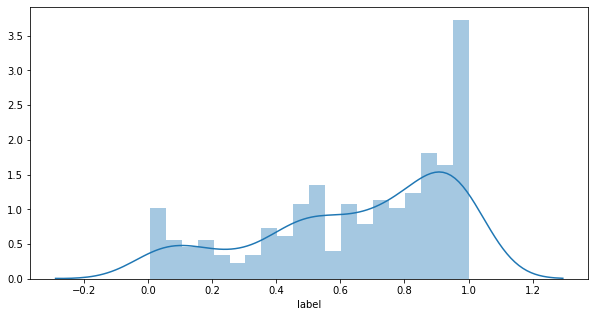

In [83]:
plt.figure(figsize=(10, 5))
sns.distplot(submission_df_resnext_train.label, bins=20)

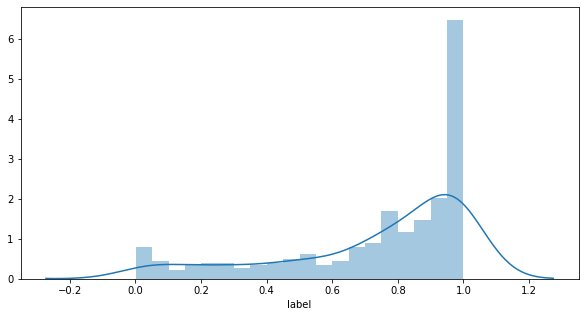

In [84]:
plt.figure(figsize=(10, 5))
sns.distplot(submission_df_xception_train.label, bins=20)

### 5.1.3 Score (log loss) for train prediction

In [0]:
df_resnext_train = submission_df_resnext_train
df_resnext_train['real_label'] = 1 - df_resnext_train['label']

In [87]:
log_loss(meta_train_df['label'], df_resnext_train[['label','real_label']])

ValueError: ignored

In [0]:
df_xception_train = submission_df_xception_train
df_xception_train['real_label'] = 1 - df_xception_train['label']

In [0]:
log_loss(meta_train_df['label'], df_xception_train[['label','real_label']])

## 5.2 Analysis Submission

test dataset 을 사용하여 prediction 한 것(submission)의 label 값의 범위, 분포 를 살펴본다.

In [0]:
submission_df_resnext = pd.read_csv(output_path+'submission_resnext.csv')
submission_df_xception = pd.read_csv(output_path+'submission_xception.csv')
submission_df = pd.read_csv(output_path+'submission.csv')

### 5.2.1 Range label for Submission

In [0]:
print(submission_df_resnext['label'].min(), submission_df_resnext['label'].max()) 

In [0]:
print(submission_df_xception['label'].min(), submission_df_xception['label'].max()) 

In [0]:
print(submission_df['label'].min(), submission_df['label'].max()) 

### 5.2.2 Plot for Submission

상황 : 
* test dataset 을 사용하여 prediction 한 경우 Resnext 와 Xception 의 분포에 차이가 많다.
* Xception 의 경우 train 과 test 의 분포가 유사하다.

의문 :
* 어떤 분포가 맞는지 판단할 방법이 있는가?
* Ensemble 조합하는 계수를 어떻게 결정할 것인가?

In [0]:
plt.figure(figsize=(10, 5))
sns.distplot(submission_df_resnext.label, bins=20)

In [0]:
plt.figure(figsize=(10, 5))
sns.distplot(submission_df_xception.label, bins=20)

In [0]:
plt.figure(figsize=(10, 5))
sns.distplot(submission_df.label, bins=20)